# Setup

## Imports

In [1]:
using Pkg
Pkg.activate("SCC", shared=true)


import QuantumToolbox as qt
import SuperconductingCavities as SC
import CairoMakie as cm
using Revise
using Dates
import JSON3

using YAXArrays

using ProgressMeter

import Optim as opt

using Logging
using MiniLoggers

using IJulia
if isdefined(Main, :IJulia)
    Main.IJulia.stdio_bytes[] = 0;
end


  Activating project at `~/.julia/environments/SCC`
[ Info: new driver key :netcdf, updating backendlist.


0

## Logger Setups

In [2]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

ConsoleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), Info, Base.CoreLogging.default_metafmt, true, 0, Dict{Any, Int64}())

# Loading Model and json

In [5]:
#Mode10 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode10/Mode10.json");
Models = [SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode$i/Mode$(i).json") for i in 1:10];

LoadError: UndefVarError: `SC` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [6]:
Models[1].params

LoadError: UndefVarError: `Models` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
Models[1].hilbertspace.Components["Transmon"].Ĥ

Quantum Object:   type=Operator   dims=[10]   size=(10, 10)   ishermitian=true
10×10 Matrix{ComplexF64}:
     -24.6406+0.0im   1.02141e-14+0.0im  …  -2.16493e-15+0.0im
  1.02141e-14+0.0im      -20.0355+0.0im      8.22256e-15+0.0im
  1.22125e-15+0.0im   1.33227e-15+0.0im     -9.71445e-15+0.0im
  3.21965e-15+0.0im   1.40574e-14+0.0im      9.09833e-15+0.0im
  1.60982e-15+0.0im  -6.10623e-15+0.0im      1.09357e-14+0.0im
  3.71925e-15+0.0im   8.06217e-15+0.0im  …    1.5304e-14+0.0im
  -4.1217e-15+0.0im   5.48867e-15+0.0im       1.4197e-14+0.0im
  3.44169e-15+0.0im  -4.01489e-18+0.0im     -3.64663e-14+0.0im
  3.33067e-15+0.0im  -3.69149e-15+0.0im      4.26326e-14+0.0im
 -2.16493e-15+0.0im   8.22256e-15+0.0im          12.4349+0.0im

In [92]:
n̂ = Models[1].n̂ₜ
letters = ["g", "e", "f", "h", "i", "j", "k","l", "m", "n", "o"]
for i in 1:9
    ψ = Models[1].dressed_states[(i-1,0)]
    ψnext = Models[1].dressed_states[(i,0)]
    println("State $(letters[i+1])→$(letters[i]) : ", abs(ψnext'*n̂*ψ))
end



State e→g : 1.672479290119045
State f→e : 2.3372497211211556
State h→f : 2.826267686555954
State i→h : 3.218984332625664
State j→i : 3.54573332066436
State k→j : 3.821390050243778
State l→k : 4.053865777895899
State m→l : 4.246961864307091
State n→m : 4.400715942674834


In [4]:
1 .+ 2

3

In [77]:
Models[1].hilbertspace.Components["Transmon"].n̂

Quantum Object:   type=Operator   dims=[10]   size=(10, 10)   ishermitian=true
10×10 Matrix{ComplexF64}:
  4.44089e-16+0.0im      -1.67293+0.0im  …   -1.95346e-6+0.0im
     -1.67293+0.0im  -2.88658e-15+0.0im     -4.33681e-16+0.0im
  1.44329e-15+0.0im      -2.33772+0.0im     -0.000234613+0.0im
    -0.023965+0.0im    -4.996e-16+0.0im      1.25247e-15+0.0im
 -6.52256e-16+0.0im    -0.0494717+0.0im       -0.0106214+0.0im
  0.000673742+0.0im  -1.52656e-15+0.0im  …  -1.06859e-15+0.0im
  5.82867e-16+0.0im   -0.00177878+0.0im        -0.277055+0.0im
  -3.00396e-5+0.0im    -1.249e-16+0.0im      7.32747e-15+0.0im
 -3.33067e-16+0.0im    -9.6396e-5+0.0im         -4.40164+0.0im
  -1.95346e-6+0.0im  -4.33681e-16+0.0im      4.92939e-14+0.0im

# Loading Data

In [5]:
data = Dict{Any, Any}()
data_upper = Dict{Any, Any}()
data_lower = Dict{Any, Any}()
for final_state in ["2", "0_p_4"]
    data[final_state] = []
    data_upper[final_state] = []
    data_lower[final_state] = []
    for i in 1:10
        push!(data[final_state], SC.Utils.LoadRunResults("Data/Mode$(i)_Prep_$(final_state).nc"))
        push!(data_upper[final_state], SC.Utils.LoadRunResults("Data/Mode$(i)_Prep_$(final_state)_upper.nc"))
        push!(data_lower[final_state], SC.Utils.LoadRunResults("Data/Mode$(i)_Prep_$(final_state)_lower.nc"))
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 

# Extracting Fidelities

In [24]:
function fidelity_func_0p4(θ, ψ, i)
    ψ0 = Models[i].dressed_states[(0,0)]
    ψ4 = Models[i].dressed_states[(0,4)]
    ψ_for_ρ = (ψ0+exp(-1im*θ[1])*ψ4)/sqrt(2)
    ρ = ψ_for_ρ*ψ_for_ρ'
    ψ_pt = qt.ptrace(ψ, 2)
    ρ_pt = qt.ptrace(ρ, 2)
    return abs(qt.expect(ρ_pt, ψ_pt))
end

fidelity_func_0p4 (generic function with 1 method)

In [25]:
fidelities = Dict{Any, Any}()
fit_res = []

fidelities_upper = Dict{Any, Any}()
fit_res_upper = []

fidelities_lower = Dict{Any, Any}()
fit_res_lower = []

for key in keys(data)
    fidelities[key] = []
    fidelities_upper[key] = []
    fidelities_lower[key] = []
    for i in 1:10
        if key == "2"
            ψ = Models[i].dressed_states[(0,2)]
            ρ =data[key][i]["states"][end]
            ψ_pt = qt.ptrace(ψ, 2)
            ρ_pt = qt.ptrace(ρ, 2)
            push!(fidelities[key], abs(qt.expect(ρ_pt, ψ_pt)))
            
            ρ =data_upper[key][i]["states"][end]
            ρ_pt = qt.ptrace(ρ, 2)
            push!(fidelities_upper[key], abs(qt.expect(ρ_pt, ψ_pt)))
            
            ρ =data_lower[key][i]["states"][end]
            ρ_pt = qt.ptrace(ρ, 2)
            push!(fidelities_lower[key], abs(qt.expect(ρ_pt, ψ_pt)))
        end
        if key == "0_p_4"
            ψ = data[key][i]["states"][end]
            to_min(θ) = abs(1-fidelity_func_0p4(θ, ψ,i))
            res = opt.optimize(to_min, [π*0.5])
            push!(fit_res, res)
            push!(fidelities[key], 1-res.minimum)

            ψ = data_upper[key][i]["states"][end]
            to_min_upper(θ) = abs(1-fidelity_func_0p4(θ, ψ,i))
            res = opt.optimize(to_min_upper, [π*0.5])
            push!(fit_res_upper, res)
            push!(fidelities_upper[key], 1-res.minimum)

            ψ = data_lower[key][i]["states"][end]
            to_min_lower(θ) = abs(1-fidelity_func_0p4(θ, ψ,i))
            res = opt.optimize(to_min_lower, [π*0.5])
            push!(fit_res_lower, res)
            push!(fidelities_lower[key], 1-res.minimum)
        end
    end
end

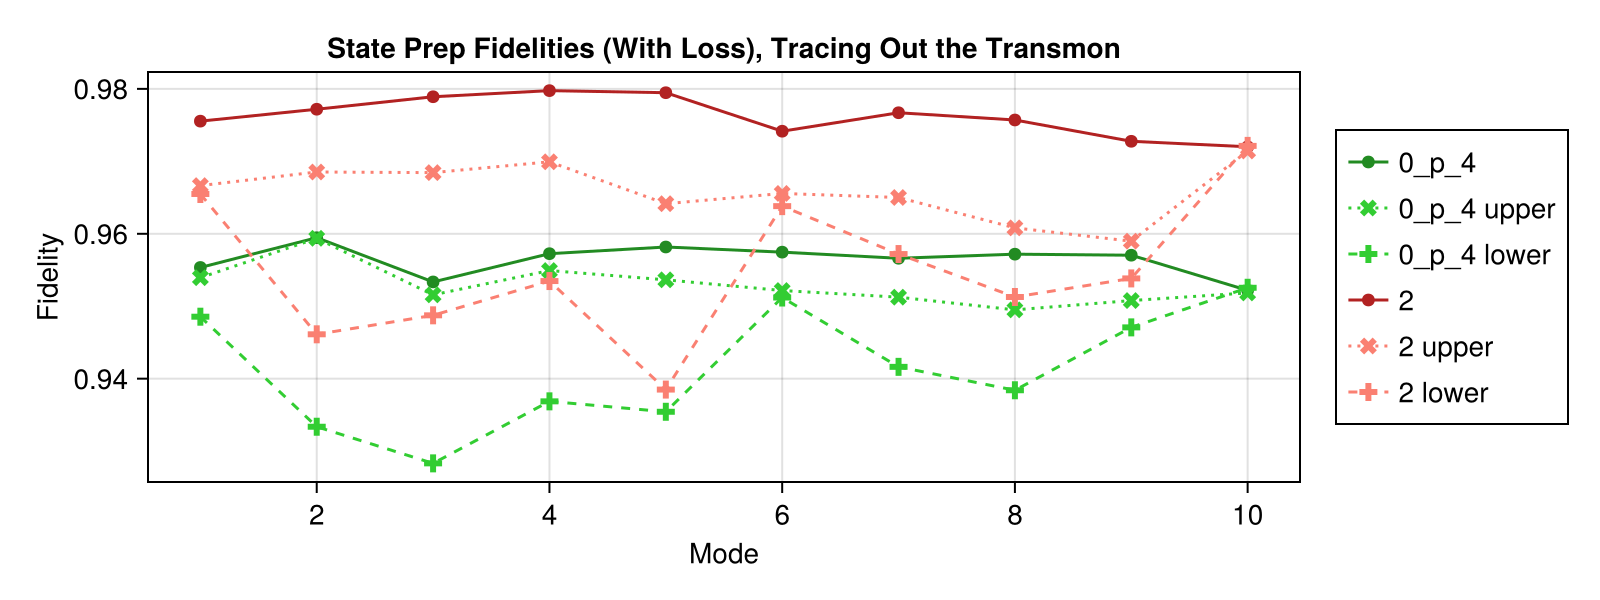

CairoMakie.Screen{IMAGE}


In [27]:
f = cm.Figure(size = (800, 300))
ax = cm.Axis(f[1, 1], xlabel = "Mode", ylabel = "Fidelity", title = "State Prep Fidelities (With Loss), Tracing Out the Transmon")

cross_size = 12
key = "0_p_4"
cm.scatterlines!(ax, 1:10, fidelities[key], label = key, color = "forestgreen")
cm.scatterlines!(ax, 1:10, fidelities_upper[key], label = key*" upper", color = "limegreen", linestyle = :dot, marker = :xcross, markersize = cross_size)
cm.scatterlines!(ax, 1:10, fidelities_lower[key], label = key*" lower", color = "limegreen", linestyle = :dash, marker = :cross, markersize = cross_size)

key = "2"
cm.scatterlines!(ax, 1:10, fidelities[key], label = key, color = "firebrick")
cm.scatterlines!(ax, 1:10, fidelities_upper[key], label = key*" upper", color = "salmon", linestyle = :dot, marker = :xcross, markersize = cross_size)
cm.scatterlines!(ax, 1:10, fidelities_lower[key], label = key*" lower", color = "salmon", linestyle = :dash, marker = :cross, markersize = cross_size)


cm.Legend(f[1,2], ax)
display(f)

In [28]:
fids_to_save = Dict{Any, Any}()
fids_to_save["fidelities"] = fidelities
fids_to_save["fidelities_upper"] = fidelities_upper
fids_to_save["fidelities_lower"] = fidelities_lower

Dict{Any, Any} with 2 entries:
  "0_p_4" => Any[0.948556, 0.933371, 0.928316, 0.936874, 0.935435, 0.951204, 0.…
  "2"     => Any[0.96549, 0.946127, 0.948746, 0.953476, 0.938498, 0.963814, 0.9…

In [30]:
#open("Data/StatePrepFidelities_Traced_Out_Transmon.json", "w") do io
#    JSON3.pretty(io, fids_to_save)
#end

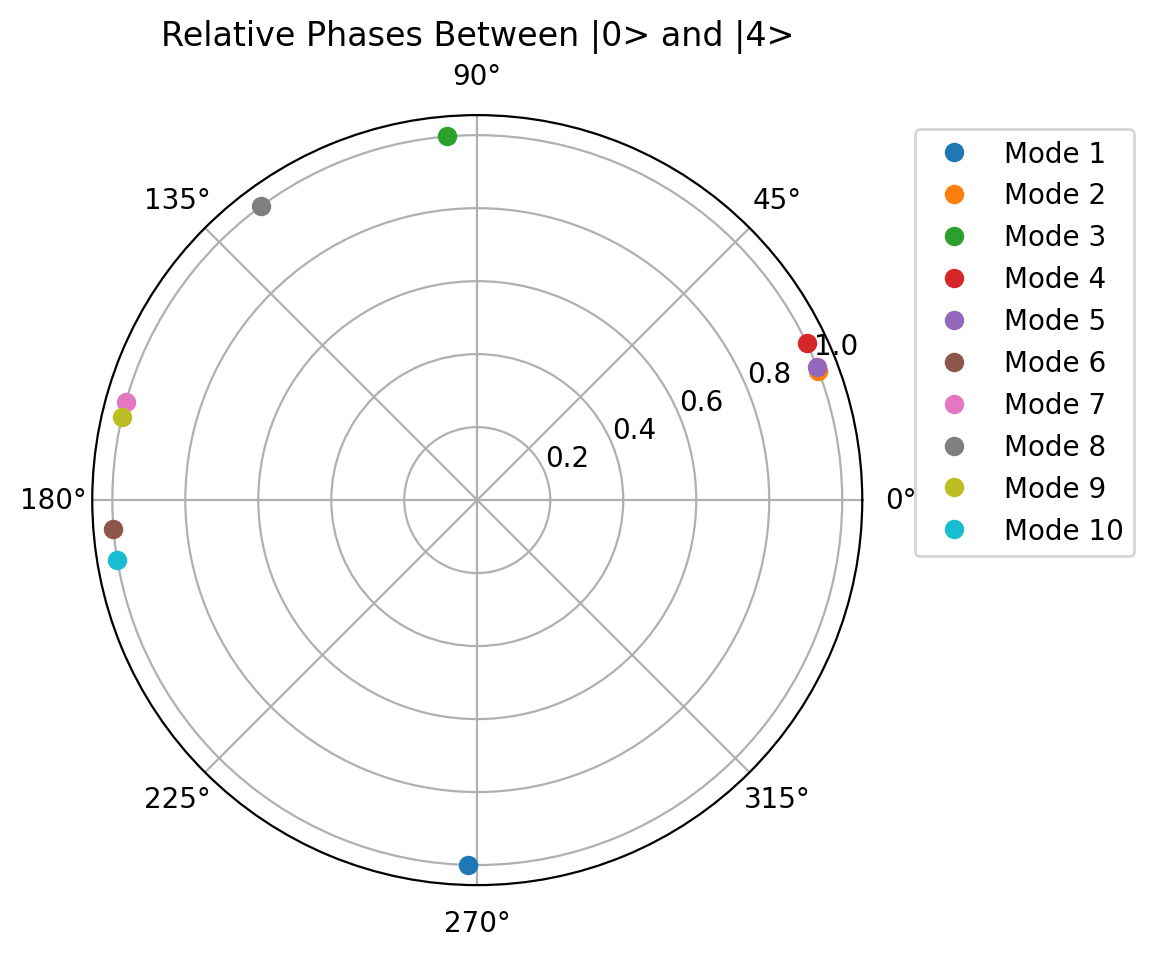

In [105]:
using PyPlot

fig = plt.figure(figsize = (5,5), dpi = 200)

ax = fig.add_subplot(111, projection = "polar")

for i in 1:length(fit_res)
    theta = [fit_res[i].minimizer[1]]
    ax.plot(theta, [1], label = "Mode $i", marker = "o", lw = 0)
end

plt.title("Relative Phases Between |0> and |4>")

plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left")
display(gcf())

# Looking at Lossless State Prep

In [79]:
i = 2
Model = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode$i/Mode$(i).json")
println(Model.Stuff["op_drive_params"]["sb_f0g1"]["epsilon"])

for key in keys(Model.Stuff["op_drive_params"])
    if string(key[1]) == "s"
        println(key)
        Model.Stuff["op_drive_params"][key]["epsilon"] *= (1-1/250)
    end
end
println(Model.Stuff["op_drive_params"]["sb_f0g1"]["epsilon"])

0.595
sb_f1g2_2pi_f3g4
sb_f2g3
sb_f0g1_4pi_f3g4
sb_half_f1g2
sb_f1g2
sb_f3g4
sb_f0g1
0.5926199999999999


In [80]:
Model.Stuff["Drive_Sequences"]

Dict{String, Any} with 8 entries:
  "Prep_0_+_2" => Any["q_ge_0", "q_half_ef0", "sb_f0g1", "q_ge_1/2", "q_ef_1/2"…
  "Prep_1"     => Any["q_ge_0", "q_ef_0", "sb_f0g1"]
  "Prep_4"     => Any["q_ge_0", "q_ef_0", "sb_f0g1", "q_ge_1", "q_ef_1", "sb_f1…
  "Prep_0_+_4" => Any["q_ge_0", "q_half_ef0", "sb_f0g1", "q_ge_1/2", "q_ef_1/2"…
  "Prep_3"     => Any["q_ge_0", "q_ef_0", "sb_f0g1", "q_ge_1", "q_ef_1", "sb_f1…
  "Prep_0_+_1" => Any["q_ge_0", "q_half_ef0", "q_ge_0", "sb_f0g1"]
  "Prep_2"     => Any["q_ge_0", "q_ef_0", "sb_f0g1", "q_ge_1", "q_ef_1", "sb_f1…
  "Prep_0_+_3" => Any["q_ge_0", "q_half_ef0", "sb_f0g1", "q_ge_1/2", "q_ef_1/2"…

## Getting Data

In [81]:
ψ0 = Model.dressed_states[(0,0)]
sim_dat = SC.Dynamics.RunPulseSequence(Model, ψ0, Model.Stuff["Drive_Sequences"]["Prep_0_+_4"], spns = "Stroboscopic")

The Name for this run is: Operator_Sequence_Mon-Nov-25-24.13.49
It is being saved at: Data/
[2024-11-25 13:49:51] Info: Running operator q_ge_0
[2024-11-25 13:49:51] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-25 13:49:53] Info: Time Evolution Complete
[2024-11-25 13:49:53] Info: Saving Steps
[2024-11-25 13:49:53] Info: Done with Step_1
[2024-11-25 13:49:53] Info: Running operator q_half_ef0
[2024-11-25 13:49:53] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-25 13:49:54] Info: Time Evolution Complete
[2024-11-25 13:49:54] Info: Saving Steps
[2024-11-25 13:49:55] Info: Done with Step_2
[2024-11-25 13:49:55] Info: Running operator sb_f0g1
[2024-11-25 13:49:55] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-25 13:49:57] Info:

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.2172, 0.4344, 0.6516, 0.8688, 1.086, 1.3032, 1.5204, 1.7376…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

## Plotting

In [82]:
proj_dict = SC.Utils.Get_Projection_Ops(Model.dressed_states);
EVs = SC.Utils.Get_EVs(sim_dat["states"], proj_dict);

[2024-11-25 13:50:23] Info: Making Plot


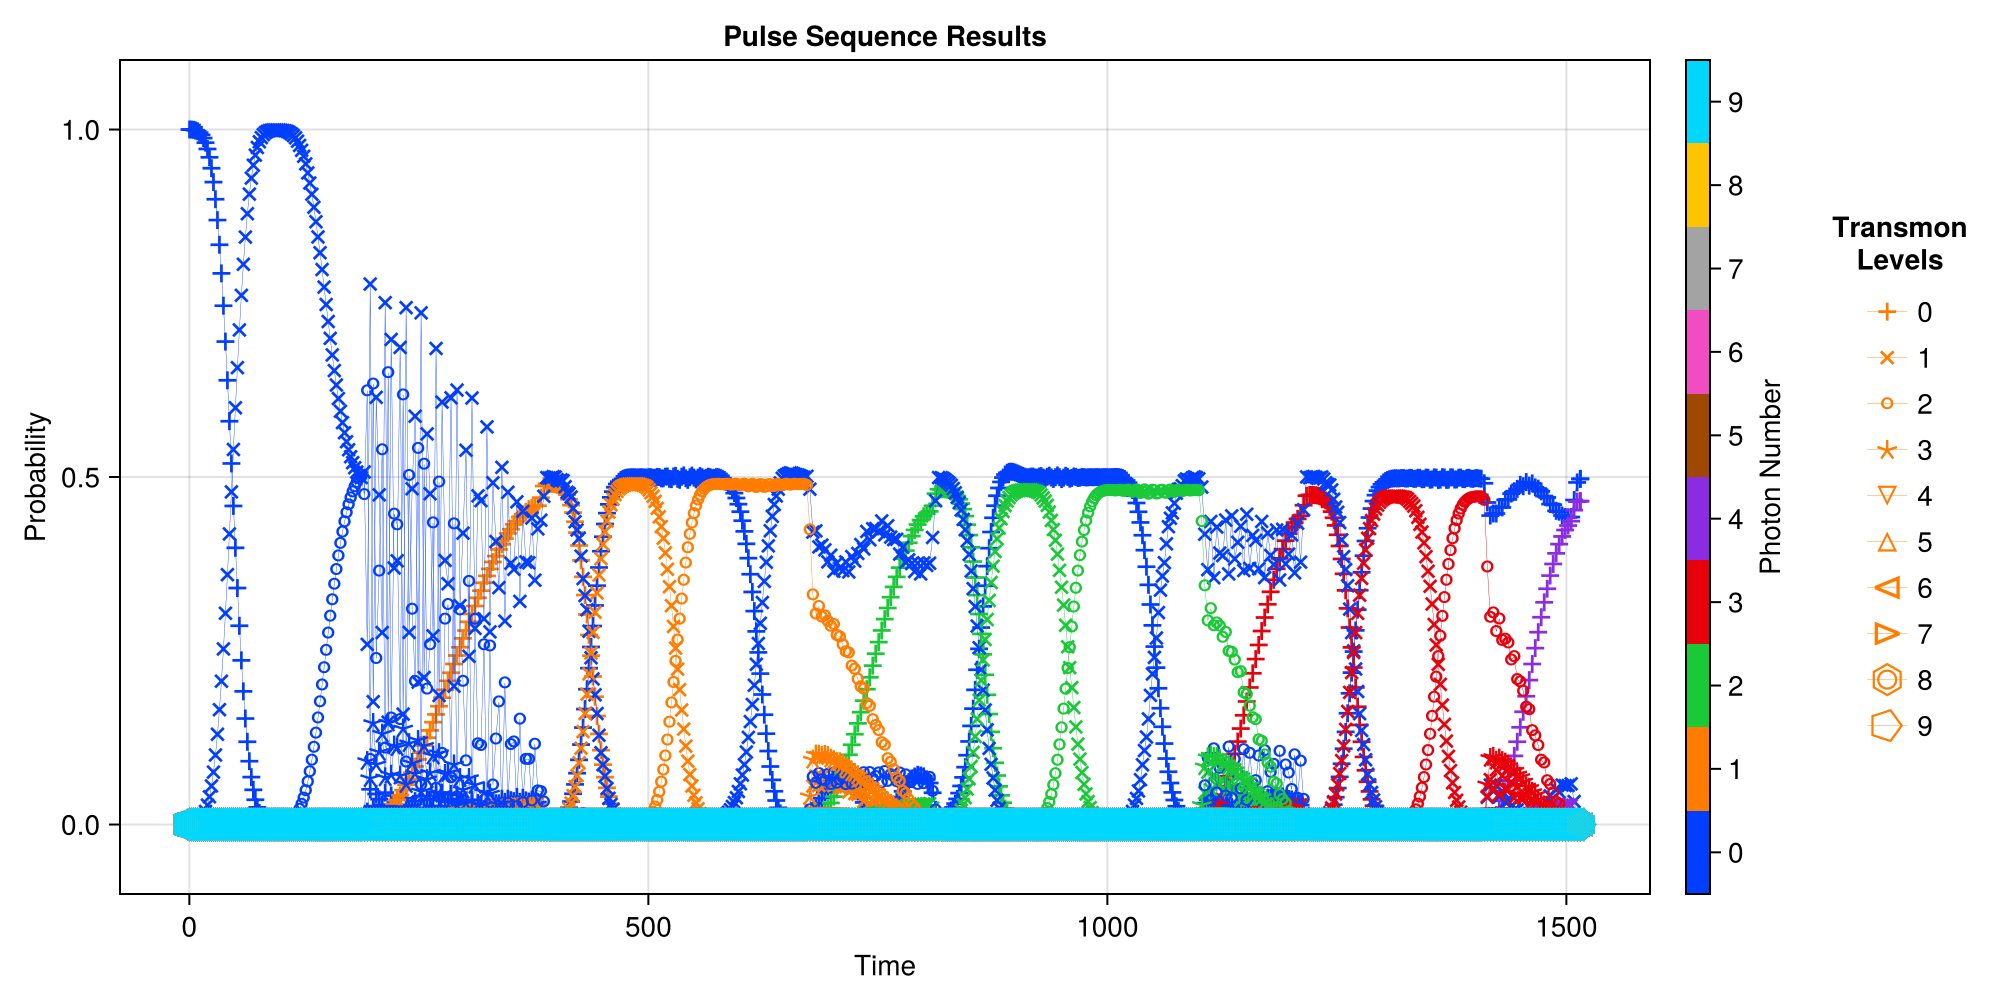

CairoMakie.Screen{IMAGE}


In [83]:
SC.Dynamics.PlotSingleModeEvolution(Model, sim_dat["times"], EVs, plot_every = 10)

## Fitting Fidelity

In [84]:
function fidelity_func_0p4(θ, ψ, i)
    ψ0 = Model.dressed_states[(0,0)]
    ψ4 = Model.dressed_states[(0,4)]
    ψ_for_ρ = (ψ0+exp(-1im*θ[1])*ψ4)/sqrt(2)
    ρ = ψ_for_ρ*ψ_for_ρ'
    return abs(qt.expect(ρ, ψ))
end

fidelity_func_0p4 (generic function with 1 method)

In [85]:
to_min(θ) = abs(1-fidelity_func_0p4(θ, sim_dat["states"][end],i));
res = opt.optimize(to_min, [π*1.0]);

In [86]:
1-res.minimum

0.9622832995329631

For Mode 2\
minus 0.4%:\
0.9622832995329631

calibrated:\
0.9864390882417317

plus 0.4%:\
0.9828364300149192



# Photon Number per Transmon Level